Под впечатлением от http://joyreactor.cc/post/3722987#comment17346813 возникла идея замапить значения из x^2+y^2-2x+6y-54=0 в изображение.

Идея такова:
- выделить линии OpenCV
- для каждой из них построить регрессию, обученную на части значений x^2+y^2-2x+6y-54=0
- построить классификатор, по точке, удовлетворяющей x^2+y^2-2x+6y-54=0 определяющий, к какой из выделенных линий она относится.
- для каждой новой точки:
  - предсказать координаты отображения всеми регрессиями отдельных линий
  - предсказать вероятности принадлежности каждой линии
  - посчитать средневзвешенные координаты, заюзав вышеуказанные вероятности как веса
  
# Подготовка

Импорты, загрузка исходного изображения и куча всего неинтересного.

In [0]:
!wget https://i.imgur.com/BgBSko6.png

In [2]:
import os

GDRIVE_DIR='gdrive'

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p {GDRIVE_DIR}
!google-drive-ocamlfuse {GDRIVE_DIR}

E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.layers import Input, Dense, Add, Dropout, Lambda, Multiply, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras import backend as K
import cv2 as cv
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import math
from sklearn.preprocessing import normalize

In [2]:
cv.__version__

'3.4.3'

# Предобработка
Здесь - чтение изображения, выделение отдельных линий

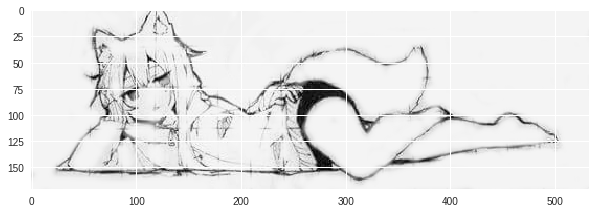

In [3]:
img = cv.imread('BgBSko6.png')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 5))
plt.imshow(255 - img)

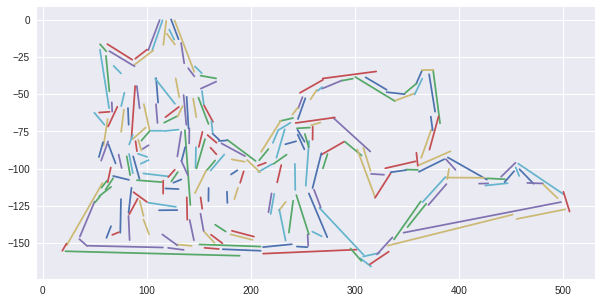

In [4]:
lsd = cv.createLineSegmentDetector(0)
lines = lsd.detect(img)[0]
plt.figure(figsize=(10, 5))
#plt.imshow(img)
lines_flat = []
for i in range(len(lines)):
  line = lines[i, :, :]
  startX, startY, endX, endY = line.ravel()
  startY = -startY
  endY = -endY  
  lines_flat.append([startX, startY, endX, endY])
  plt.plot([startX, endX],
           [startY, endY])

# Решения исходного уравнения

Если точнее - здесь выделяю функции y(x) (их две).

x^2 + y^2 - 2x + 6y - 54 = 0

y^2 + 6y + x^2 - 2x - 54 = 0

y^2 + 6y + (x^2 - 2x - 54) = 0

D = b^2 - 4ac = 36 - 4(x^2 - 2x - 54)

D > 0

-7 < x < 9

y = -6 +/- sqrt(D) / 2

In [0]:
point_count = len(lines_flat) * 100.0

In [0]:
diapazone = 8.99 - (-6.99)
step = 2 * diapazone / point_count
x = np.arange(-6.99, 8.99, step)
x_test = np.arange(-6.99, 8.99, 0.05 * step)

In [0]:
def get_y(x, sign):
  D = 36 - 4 * (x ** 2 - 2 * x - 54)
  return -6 + sign * np.sqrt(D) / 2.0

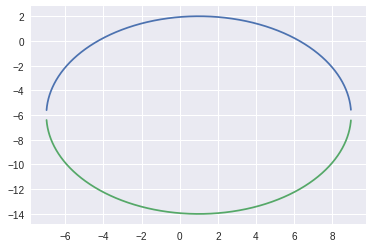

In [8]:
plt.plot(x, get_y(x, 1))
plt.plot(x, get_y(x, -1))

# Регрессии отдельных линий

In [0]:
source_x = np.hstack([x, x])
source_y = np.hstack([get_y(x, 1), get_y(x, -1)])
source_x_test = np.hstack([x_test, x_test])
source_y_test = np.hstack([get_y(x_test, 1), get_y(x_test, -1)])

In [10]:
part_models = []
for i, line in enumerate(tqdm(lines_flat)):
  startX, startY, endX, endY = line
  target = np.zeros([100, 2])
  target[:, 0] = np.arange(startX, endX, (endX-startX)/100.0)[:100]
  target[:, 1] = np.arange(startY, endY, (endY-startY)/100.0)[:100]
  source = np.zeros([100, 2])
  source[:, 0] = source_x[i*100 : (i+1)*100]
  source[:, 1] = source_y[i*100 : (i+1)*100]
  model = Pipeline([
      ('poly', PolynomialFeatures()),
      ('scaler', StandardScaler()),
      ('reg', LinearRegression())
  ])
  model.fit(source, target)
  part_models.append(model)

100%|██████████| 229/229 [00:00<00:00, 713.39it/s]


100%|██████████| 229/229 [00:00<00:00, 287.70it/s]


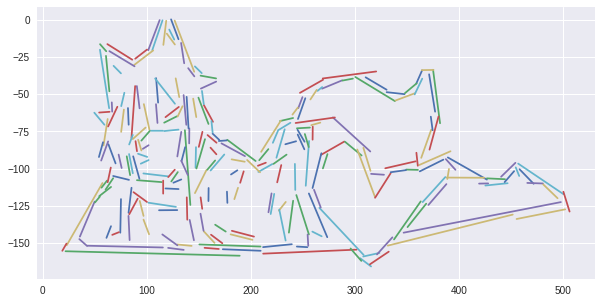

In [150]:
plt.figure(figsize=(10, 5))
for i in tqdm(range(len(lines_flat))):
  source = np.zeros([2000, 2])
  source[:, 0] = source_x_test[i*2000 : (i+1)*2000]
  source[:, 1] = source_y_test[i*2000 : (i+1)*2000]
  pred = part_models[i].predict(source)
  plt.plot(pred[:, 0], pred[:, 1])

# Опредедение принадлежности точки в исходном пространстве линиям в новом пространстве

In [0]:
source_classes = []
for i in range(len(lines)):
  source_classes += [i] * 100
source_classes = np.array(source_classes)

In [0]:
source = np.zeros([len(source_x), 2])
source[:, 0] = source_x
source[:, 1] = source_y
source_test = np.zeros([len(source_x_test), 2])
source_test[:, 0] = source_x_test
source_test[:, 1] = source_y_test

In [112]:
line_classifier = Pipeline([
  ('poly', PolynomialFeatures(10)),
  ('scaler', StandardScaler()),
  ('clf', LogisticRegression(max_iter=200))
])
#line_classifier = KNeighborsClassifier(metric='euclidean')
line_classifier.fit(source, source_classes)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [152]:
probabilities = []
batch_count = int(math.ceil(len(source_test) / 1000.0))
for i in tqdm(range(batch_count)):
  probabilities.append(line_classifier.predict_proba(source_test[i * 1000 : (i + 1) * 1000]))
probabilities = np.vstack(probabilities)

100%|██████████| 458/458 [00:08<00:00, 55.94it/s]


(array([270268., 123011.,  34484.,  13761.,   6938.,   4957.,   2969.,
           295.,    378.,    939.]),
 array([0.03711334, 0.10697782, 0.1768423 , 0.24670678, 0.31657126,
        0.38643574, 0.45630023, 0.52616471, 0.59602919, 0.66589367,
        0.73575815]),
 <a list of 10 Patch objects>)

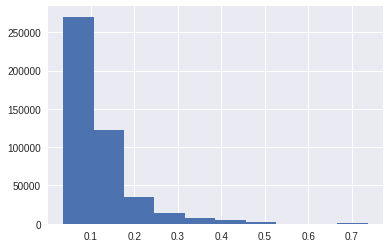

In [158]:
plt.hist(probabilities.max(axis=1))

Какое-то не найс распределение вероятностей. На таких весах можно уехать совсем не туда (и я уезжал).

In [0]:
def softargmax(probabilities, beta):
  return (np.exp(beta * probabilities) * np.arange(1, probabilities.shape[1] + 1)) / np.sum(np.exp(beta * probabilities), axis=1).reshape([-1,1])

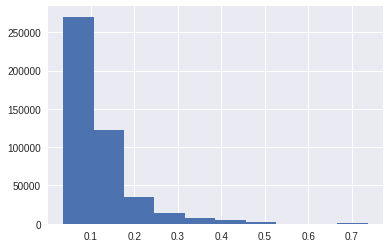

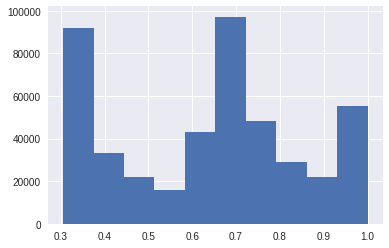

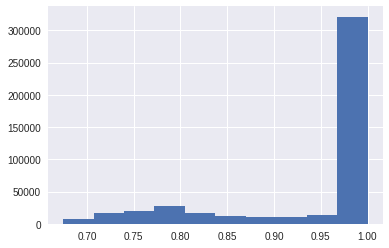

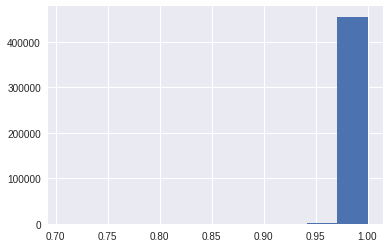

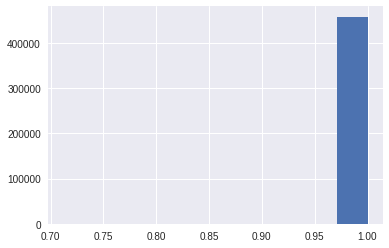

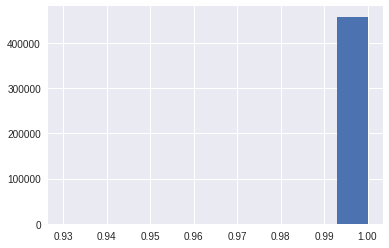

In [153]:
probabilities_processed = probabilities
plt.figure()
plt.hist(probabilities_processed.max(axis=1))
for i in range(5):
  probabilities_processed = softargmax(probabilities_processed, 100)
  probabilities_processed = normalize(probabilities_processed, axis=1)
  plt.figure()
  plt.hist(probabilities_processed.max(axis=1))

Вот так уже намного лучше - почти 100% уверенности :-)

# Результат

Здесь я строю результирующее изображение

In [154]:
X = np.zeros([len(source_test)])
y = np.zeros([len(source_test)])
for i in tqdm(range(len(lines_flat))):
  prediction = part_models[i].predict(source_test)
  X += prediction[:, 0] * probabilities_processed[:, i]
  y -= prediction[:, 1] * probabilities_processed[:, i]
X /= len(lines_flat)
y /= len(lines_flat)

100%|██████████| 229/229 [00:35<00:00,  6.46it/s]


In [0]:
X = (MinMaxScaler().fit_transform(X.reshape([-1, 1]))[:, 0] * (img.shape[1] - 1)).astype(np.int32)
y = (MinMaxScaler().fit_transform(y.reshape([-1, 1]))[:, 0] * (img.shape[0] - 1)).astype(np.int32)

In [0]:
new_img = np.zeros(img.shape).astype(np.bool)
new_img[y, X] = True

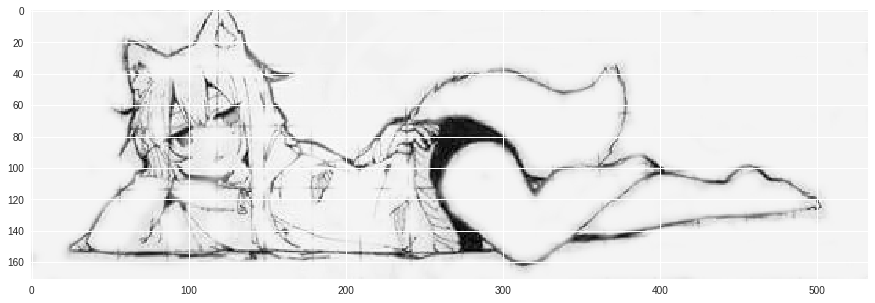

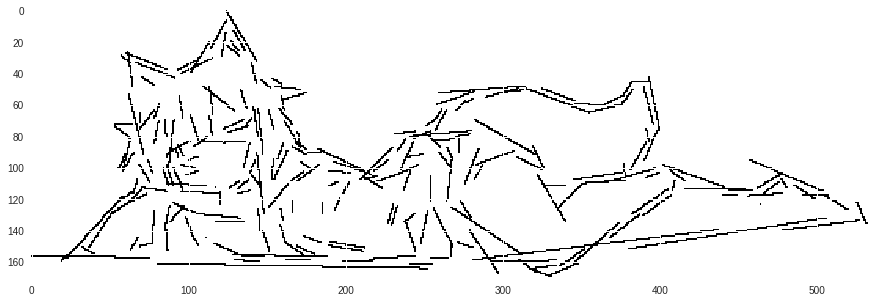

In [157]:
plt.figure(figsize=(15, 5))
plt.imshow(255.0 - img)
plt.figure(figsize=(15, 5))
plt.imshow(new_img)